In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential, Input

%load_ext autoreload

# %aimport covid_flu
# cf = covid_flu
import covid_flu as cf

%autoreload 2
%matplotlib inline

# Incorporating state information

In this notebook, we take the best models used in `0_rnn_flu.ipynb` and add in state-specific information. We will try the following approaches:

1. Adding an embedding layer that is concatenated with the final hidden state in the FCN block
2. Adding a feature layer (based on state features) that is concatenated with the final hidden state in the FCN block

Then, we will attempt a model that jointly predicts all states at once.

Input: `(batch_size, max_history_len, n_states)`

Output: `(batch_size, target_len, n_states)`

We will attempt an attention mechanism in the FCN block that takes into account state neighbour relations and state commuting relations.

## Preparing Data

In [2]:
# Hyperparams
TEST_SIZE = 0.2
MAX_LEN = 368
MAX_HISTORY_LEN = MAX_LEN - 1
MIN_HISTORY_LEN = 25
TARGET_LEN = 1
PAD_VAL = -1

In [3]:
df_flu = cf.utils.load_flu_data()
df_flu.head()

states = df_flu['state'].unique()
n_states = len(states)

In [4]:
states

array(['Texas', 'Louisiana', 'Washington', 'New Jersey', 'Arkansas',
       'Montana', 'North Dakota', 'Nebraska', 'New Mexico', 'Indiana',
       'California', 'Ohio', 'South Carolina', 'Rhode Island', 'Michigan',
       'Georgia', 'Wyoming', 'Hawaii', 'New Hampshire', 'Maryland',
       'Mississippi', 'Connecticut', 'West Virginia', 'Iowa', 'Illinois',
       'Vermont', 'Tennessee', 'Missouri', 'Wisconsin', 'North Carolina',
       'Pennsylvania', 'Kentucky', 'Delaware', 'Kansas', 'Oregon',
       'Massachusetts', 'Alabama', 'Alaska', 'Arizona', 'Minnesota',
       'Maine', 'Nevada', 'Idaho', 'Utah', 'Virginia', 'New York',
       'District of Columbia', 'Oklahoma', 'South Dakota', 'Colorado'],
      dtype=object)

In [5]:
X_train, X_test = cf.time_series.train_test_split(df_flu['wili'].values,
                                                  df_flu['state'].values,
                                                  test_size=TEST_SIZE)

In [6]:
X_train_var, y_train = cf.time_series.prepare_all_data_walk_forward(X_train,
                                                                    min_len=MIN_HISTORY_LEN,
                                                                    max_len=MAX_LEN,
                                                                    target_len=TARGET_LEN,
                                                                    pad_val=PAD_VAL)
# # The validation set adds a bit of the training set (the last `MIN_HISTORY_LEN`)
# X_test_aug = []
# for x_train, x_test in zip(X_train, X_test):
#     X_test_aug.append(np.concatenate((x_train[-MIN_HISTORY_LEN:], x_test)))
    
X_test_var, y_test = cf.time_series.prepare_all_data_walk_forward(X_test,
                                                                  min_len=MIN_HISTORY_LEN,
                                                                  max_len=MAX_LEN,
                                                                  target_len=TARGET_LEN,
                                                                  pad_val=PAD_VAL)

ds_train, ds_test = cf.time_series.make_datasets(X_train_var,
                                                 X_test_var,
                                                 y_train,
                                                 y_test)


## Simple LSTM model (one state at a time)

Input: `(batch_size, max_history_len, 1)`

Output: `(batch_size, target_len, 1)`

In [7]:
# Defining hyperparams
BATCH_SIZE = 64
EPOCHS = 10
HIDDEN_SIZE = 32
PRE_OUTPUT_DENSE_SIZE = 32

def make_masked_lstm(max_len,
                     target_len=1,
                     hidden_size=16,
                     mask_value=-1,
                     pre_output_dense_size=None,
                     dropout_rate=0.):
    model = tf.keras.models.Sequential()
    model.add(layers.Masking(mask_value=mask_value, input_shape=(max_len, 1)))
    model.add(layers.LSTM(hidden_size))
    if pre_output_dense_size:
        model.add(layers.Dense(pre_output_dense_size, activation='relu'))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(target_len))
    
    model.compile(optimizer='adam', loss='mse')
    return model

In [8]:
lstm1 = make_masked_lstm(MAX_LEN,
                         TARGET_LEN,
                         HIDDEN_SIZE,
                         mask_value=PAD_VAL,
                         pre_output_dense_size=PRE_OUTPUT_DENSE_SIZE)
lstm1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 368, 1)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________


In [9]:
history1 = lstm1.fit(ds_train,
                     validation_data=ds_test,
                     epochs=EPOCHS)

Train for 67 steps, validate for 14 steps
Epoch 1/10
67/67 [==============================] - 59s 876ms/step - loss: 3.7273 - val_loss: 2.2532
Epoch 2/10
67/67 [==============================] - 47s 706ms/step - loss: 1.3286 - val_loss: 0.6899
Epoch 3/10
67/67 [==============================] - 53s 791ms/step - loss: 0.5851 - val_loss: 0.3951
Epoch 4/10
67/67 [==============================] - 50s 749ms/step - loss: 0.4507 - val_loss: 0.3798
Epoch 5/10
67/67 [==============================] - 56s 841ms/step - loss: 0.4176 - val_loss: 0.3361
Epoch 6/10
67/67 [==============================] - 56s 836ms/step - loss: 0.4041 - val_loss: 0.3540
Epoch 7/10
67/67 [==============================] - 52s 784ms/step - loss: 0.3976 - val_loss: 0.3173
Epoch 8/10
67/67 [==============================] - 39s 583ms/step - loss: 0.3941 - val_loss: 0.3489
Epoch 9/10
67/67 [==============================] - 38s 566ms/step - loss: 0.3871 - val_loss: 0.3287
Epoch 10/10
67/67 [==============================

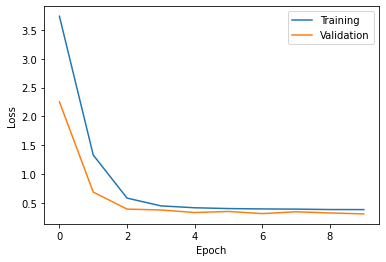

In [10]:
cf.plotting.plot_history(history1)

## Adding state information

In [11]:
# Encoding state
id2state = {i: state for i, state in enumerate(states)}
state2id = {state: i for i, state in enumerate(states)}
state_ids = [state2id[state] for state in states]

In [15]:
data_train = cf.time_series.prepare_all_data_walk_forward(X_train,
                                                          min_len=MIN_HISTORY_LEN,
                                                          max_len=MAX_LEN,
                                                          target_len=TARGET_LEN,
                                                          pad_val=PAD_VAL,
                                                          extra_info=state_ids)

data_test = cf.time_series.prepare_all_data_walk_forward(X_test,
                                                         min_len=MIN_HISTORY_LEN,
                                                         max_len=MAX_LEN,
                                                         target_len=TARGET_LEN,
                                                         pad_val=PAD_VAL,
                                                         extra_info=state_ids)

ds_train_state = cf.time_series.make_dataset(data_train)
ds_test_state = cf.time_series.make_dataset(data_test)

In [16]:
STATE_EMBED_SIZE = 16

def make_masked_state_lstm(max_len,
                           state_embed_size,
                           target_len=1,
                           hidden_size=16,
                           mask_value=-1,
                           pre_output_dense_size=32):
    
    ts_input = Input(shape=(max_len, 1))
    state_input = Input(shape=(1,))
    
    x = layers.Masking(mask_value=mask_value)(ts_input)
    x = layers.LSTM(hidden_size)(x)    
    y = layers.Embedding(n_states, state_embed_size)(state_input)
    y = layers.Flatten()(y)
    x = layers.Concatenate()([x, y])
    x = layers.Dense(pre_output_dense_size, activation='relu')(x)
    x = layers.Dense(1, activation='linear')(x)
    
    model = Model(inputs=[ts_input, state_input], outputs=x)
    model.compile(optimizer='adam', loss='mse')
    return model

In [17]:
lstm_state = make_masked_state_lstm(MAX_LEN,
                                    STATE_EMBED_SIZE,
                                    target_len=TARGET_LEN,
                                    hidden_size=HIDDEN_SIZE,
                                    mask_value=PAD_VAL,
                                    pre_output_dense_size=PRE_OUTPUT_DENSE_SIZE)
lstm_state.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 368, 1)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
masking_1 (Masking)             (None, 368, 1)       0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 16)        800         input_2[0][0]                    
______________________________________________________________________________________________

In [18]:
history_state = lstm_state.fit(ds_train_state,
                               validation_data=ds_test_state,
                               epochs=EPOCHS)

Train for 67 steps, validate for 14 steps
Epoch 1/10
67/67 [==============================] - 49s 724ms/step - loss: 2.0403 - val_loss: 0.8976
Epoch 2/10
67/67 [==============================] - 38s 562ms/step - loss: 0.6488 - val_loss: 0.4097
Epoch 3/10
67/67 [==============================] - 41s 605ms/step - loss: 0.4337 - val_loss: 0.3382
Epoch 4/10
67/67 [==============================] - 76s 1s/step - loss: 0.3887 - val_loss: 0.3200
Epoch 5/10
67/67 [==============================] - 61s 913ms/step - loss: 0.3699 - val_loss: 0.3151
Epoch 6/10
67/67 [==============================] - 43s 636ms/step - loss: 0.3628 - val_loss: 0.3077
Epoch 7/10
67/67 [==============================] - 50s 744ms/step - loss: 0.3573 - val_loss: 0.3234
Epoch 8/10
67/67 [==============================] - 51s 766ms/step - loss: 0.3503 - val_loss: 0.3031
Epoch 9/10
67/67 [==============================] - 41s 614ms/step - loss: 0.3412 - val_loss: 0.3293
Epoch 10/10
67/67 [==============================] -

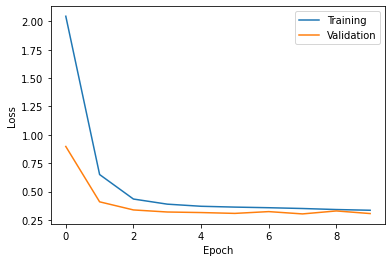

In [19]:
cf.plotting.plot_history(history_state)

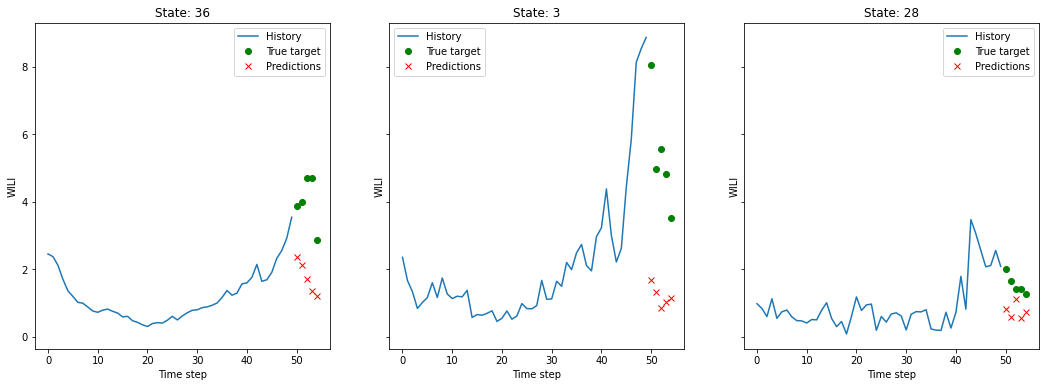

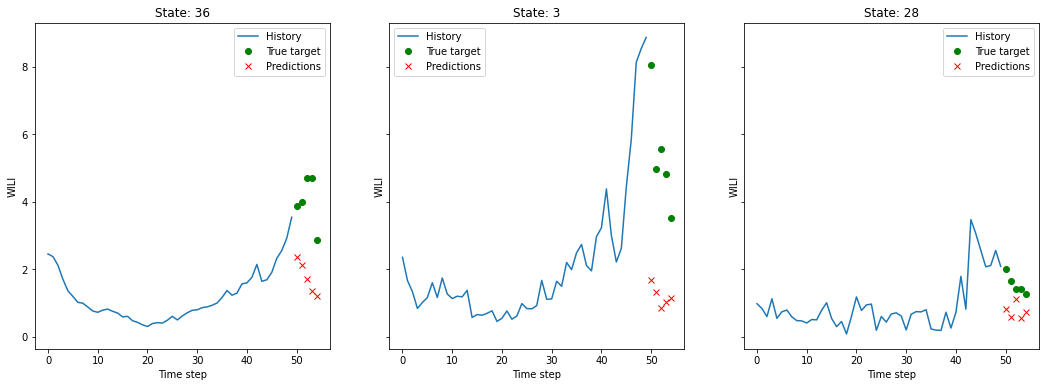

In [25]:
idxs = np.random.choice(len(X_test), size=3)
cf.plotting.plot_model_pred_sequential(lstm1, X_test, n=3, offset=20, idxs=idxs)
plt.show()
cf.plotting.plot_model_pred_sequential(lstm_state, X_test, n=3, offset=20, idxs=idxs,states=True)
plt.show()

It appears as though the state embeddings are having no effect...

In [93]:
state_embeds = lstm_state.get_layer('embedding_6').get_weights()
state_embeds = np.array(state_embeds)[0]
state_embeds.shape

(53, 16)

In [94]:
pca = PCA(n_components=2)
state_embeds_pca = pca.fit_transform(state_embeds)

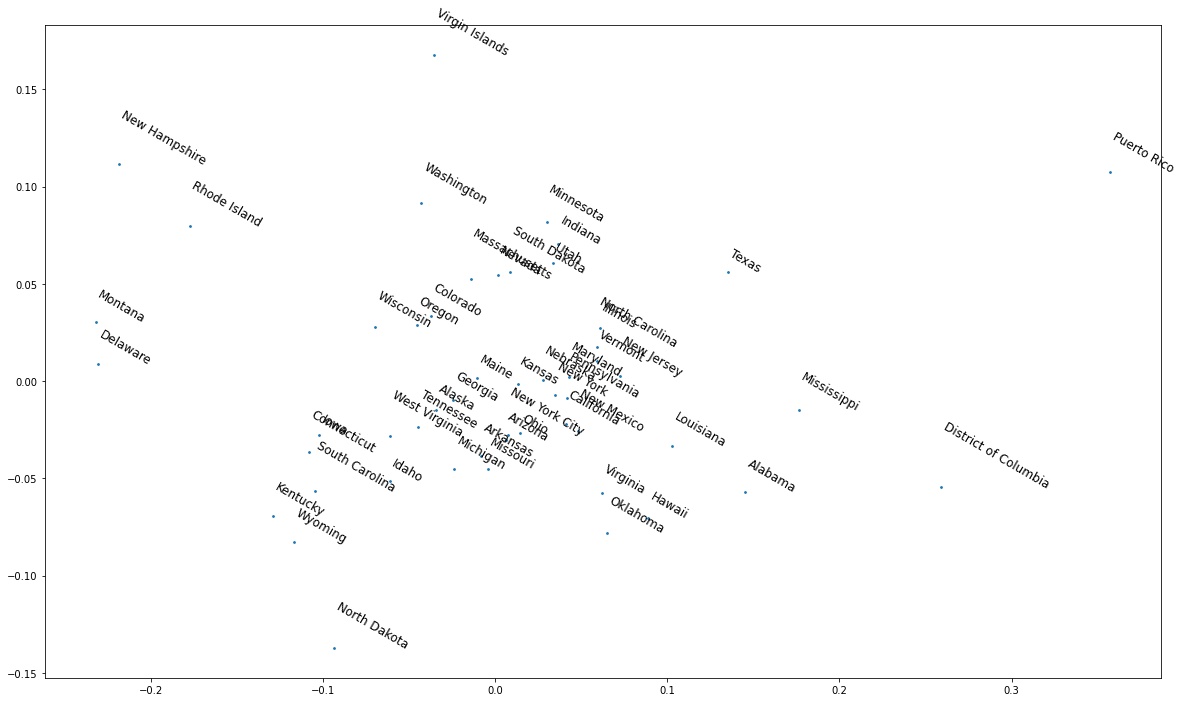

In [106]:
plt.figure(figsize=(20, 12))
plt.scatter(state_embeds_pca[:, 0], state_embeds_pca[:, 1], s=3)
for idx, state in id2state.items():
    plt.annotate(state, (state_embeds_pca[idx, 0], state_embeds_pca[idx, 1]), rotation=-30, size=12)